In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ipywidgets as widgets

/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Iteration 3

### New datapoints

* OSM > Traffic features
* OSM > Traffic features (polygons)
* OSM > Land Use

### "Narrow" datasets for a selection of models

* ElasticNet: force much smaller models
* LARSRegressor


### New models

* Principal component regression

### Updated models

* Overfitted CatBoost on some modalities (high R2 on train, low R2 on test)

### Infer on Quentin's dataset

# New datapoints

### Traffic features from OSM

In [12]:
OSM_POI_path = "../data/raw/belgium-latest-free.shp/gis_osm_pois_free_1.shp"

In [13]:
osm_poi_df = gpd.read_file(OSM_POI_path)
print(osm_poi_df.shape[0], "objecten")

161061 objecten


In [14]:
osm_poi_df.head()

,osm_id,code,fclass,name,geometry
0,18635970,2592,vending_parking,None,POINT (4.69208 50.88016)
1,25232783,2008,town_hall,Gemeentehuis Maasmechelen,POINT (5.69645 50.96325)
2,26860143,2723,monument,Insectenhotel,POINT (4.37822 50.93538)
3,26860151,2422,camp_site,Lombarde,POINT (2.75326 51.15570)
4,26860158,2422,camp_site,Treloy,POINT (5.01278 50.43278)


In [8]:
_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(osm_tl_df.fclass.value_counts())
pd.options.display.max_rows = _mr

bench                  32172
waste_basket           17957
tourist_info            8718
restaurant              8164
camera_surveillance     6195
artwork                 4289
recycling_glass         3993
post_box                3953
fast_food               3932
pub                     3721
clothes                 3592
memorial                2994
wayside_shrine          2608
pharmacy                2449
cafe                    2422
hairdresser             2387
bank                    2349
bakery                  2260
wayside_cross           1959
convenience             1818
vending_any             1679
supermarket             1676
vending_parking         1589
recycling_clothes       1543
playground              1385
picnic_site             1363
viewpoint               1267
doctors                 1134
bar                     1095
butcher                 1057
school                  1019
car_dealership           976
recycling                965
toilet                   964
bicycle_rental

Some categories of interest:
 * traffic features
     * bench
     * shelter
     * wayside_shrine (kappel, maria/jezus beeld)
     * waste_basket
     * camera_surveillance
     * fountain
     * drinking_water
     * dog_park
     * artwork
 * food
     * dine
         * restaurant
         * fast_food
         * pub
         * bar
     * shop
         * butcher
         * beverages (automaten?)
         * greengrocer
         * bakery
 * commercial venues
     * small venues
         * hairdresser
         * beauty_shop
         * pharmacy
         * bank
         * general (store: dorpswinkel)
         * convenience
         * vending_any
         * bicycle_shop
         * shoe_shop
         * book_shop
         * video_shop
         * toy_shop
         * furniture_shop
         * clothes
         * florist
         * sports_shop
     * large venues
         * supermarket
         * doityourself
         * garden_centre
 * services
     * public
         * community_center
         * library
         * post_office
         * recycling
     * school
         * university
         * college
         * school
     * health
         * doctors
         * optician
         * dentist
         * chemist (apotheek)
     * culture
         * theater
         * ruins
         * battlefield
         * museum
         * viewpoint
         * castle
         * arts_centre
         * nightclub
         * theme_park
         * zoo
     * sports
         * swimming_pool
         * sports_centre
     * stay
         * hotel
         * motel
         * guesthouse
     * car related
         * car_dealership
         * car_wash
     * kindergarten
     * toilet
     * vending_parking
 * 

In [9]:
OSM_POI_A_path = "../data/raw/belgium-latest-free.shp/gis_osm_pois_a_free_1.shp"
osm_poi_a_df = gpd.read_file(OSM_POI_A_path)

In [10]:
osm_poi_a_df

,osm_id,code,fclass,name,geometry
0,3515361,2721,attraction,Simon Stevinplein,"POLYGON ((3.22232 51.20675, 3.22262 51.20699, ..."
1,3516686,2204,park,Minnewaterpark,"POLYGON ((3.22407 51.19835, 3.22414 51.19846, ..."
2,3517578,2204,park,Parc de Bruxelles - Warandepark,"POLYGON ((4.36072 50.84331, 4.36072 50.84333, ..."
3,3517898,2721,attraction,Grand-Place - Grote Markt,"POLYGON ((4.35173 50.84692, 4.35181 50.84695, ..."
4,4005361,2204,park,Middenbermpark,"POLYGON ((4.69876 50.86857, 4.69882 50.86863, ..."
...,...,...,...,...,...
102787,1037713520,2082,school,Athénée Royal Orsini Dewerpe,"POLYGON ((4.42904 50.43912, 4.42940 50.43954, ..."
102788,1037775215,2421,shelter,None,"POLYGON ((4.04727 51.08074, 4.04729 51.08075, ..."
102789,1037777259,2253,swimming_pool,None,"POLYGON ((4.83207 51.22445, 4.83211 51.22448, ..."
102790,1037777266,2253,swimming_pool,None,"POLYGON ((4.83158 51.22402, 4.83164 51.22406, ..."


In [16]:
_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(osm_poi_a_df.fclass.value_counts())
pd.options.display.max_rows = _mr

pitch                17554
swimming_pool        14205
shelter              12912
school                6012
park                  5716
playground            4346
graveyard             3763
restaurant            2598
sports_centre         2489
supermarket           1746
community_centre      1680
chalet                1630
castle                1530
pub                   1407
fast_food             1180
car_dealership         932
cafe                   782
clothes                780
tower                  726
wastewater_plant       648
bakery                 646
pharmacy               643
university             575
bank                   568
hotel                  557
attraction             540
hairdresser            506
doityourself           483
track                  481
water_tower            479
town_hall              478
camp_site              468
museum                 433
convenience            405
guesthouse             403
dog_park               375
doctors                365
r

In [44]:
osm_traffic_a_df.geometry.centroid

/var/folders/2t/4_2_xb310651hzh4k0llnfzw0000gp/T/ipykernel_28428/826710668.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osm_traffic_a_df.geometry.centroid


0        POINT (4.38077 50.81380)
1        POINT (4.41548 51.23376)
2        POINT (4.43251 51.19816)
3        POINT (4.45859 51.20665)
4        POINT (4.46554 51.20785)
                   ...           
52778    POINT (4.82974 51.22253)
52779    POINT (4.05082 51.06709)
52780    POINT (4.05059 51.06665)
52781    POINT (4.05036 51.06623)
52782    POINT (4.04959 51.06622)
Length: 52783, dtype: geometry

In [51]:
OSM_TRAFFIC_A_path = "../data/raw/belgium-latest-free.shp/gis_osm_traffic_a_free_1.shp"
osm_traffic_a_df = gpd.read_file(OSM_TRAFFIC_A_path)
osm_traffic_a_df["trfeatp"] = osm_traffic_a_df["fclass"]
osm_traffic_a_df["poly"] = osm_traffic_a_df.geometry
osm_traffic_a_df.geometry = osm_traffic_a_df.geometry.centroid

_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(osm_traffic_a_df.fclass.value_counts())
pd.options.display.max_rows = _mr
osm_traffic_a_df

parking                48452
parking_bicycle         2321
fuel                     882
pier                     701
parking_multistorey      140
parking_underground      117
marina                    67
service                   53
dam                       25
weir                      13
slipway                    6
lock_gate                  5
waterfall                  1
Name: fclass, dtype: int64


/var/folders/2t/4_2_xb310651hzh4k0llnfzw0000gp/T/ipykernel_28428/436030143.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osm_traffic_a_df.geometry = osm_traffic_a_df.geometry.centroid


,osm_id,code,fclass,name,geometry,trfeatp,poly
0,4306844,5260,parking,None,POINT (4.38077 50.81380),parking,"POLYGON ((4.37992 50.81390, 4.37995 50.81391, ..."
1,4322795,5302,marina,Kempisch dok,POINT (4.41548 51.23376),marina,"POLYGON ((4.41428 51.23454, 4.41437 51.23454, ..."
2,4342899,5260,parking,Station,POINT (4.43251 51.19816),parking,"POLYGON ((4.43216 51.19844, 4.43216 51.19848, ..."
3,4408608,5260,parking,None,POINT (4.45859 51.20665),parking,"POLYGON ((4.45761 51.20629, 4.45770 51.20642, ..."
4,4416919,5260,parking,None,POINT (4.46554 51.20785),parking,"POLYGON ((4.46511 51.20764, 4.46533 51.20787, ..."
...,...,...,...,...,...,...,...
52778,1037779772,5260,parking,None,POINT (4.82974 51.22253),parking,"POLYGON ((4.82948 51.22245, 4.82970 51.22258, ..."
52779,1037816002,5260,parking,None,POINT (4.05082 51.06709),parking,"POLYGON ((4.05076 51.06700, 4.05086 51.06719, ..."
52780,1037816003,5260,parking,None,POINT (4.05059 51.06665),parking,"POLYGON ((4.05040 51.06633, 4.05075 51.06698, ..."
52781,1037816004,5260,parking,None,POINT (4.05036 51.06623),parking,"POLYGON ((4.05031 51.06615, 4.05039 51.06631, ..."


In [29]:
OSM_TRAFFIC_path = "../data/raw/belgium-latest-free.shp/gis_osm_traffic_free_1.shp"
osm_traffic_df = gpd.read_file(OSM_TRAFFIC_path)
osm_traffic_df["trfeat"] = osm_traffic_df["fclass"]
_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(osm_traffic_df.fclass.value_counts())
pd.options.display.max_rows = _mr
osm_traffic_df

crossing               91072
street_lamp            60205
traffic_signals        11001
turning_circle          8946
parking_bicycle         8177
stop                    3134
parking                 2126
fuel                    2086
speed_camera            1092
motorway_junction       1079
mini_roundabout          451
lock_gate                283
weir                     254
parking_underground      246
slipway                  141
marina                    70
waterfall                 62
parking_multistorey       32
dam                       27
pier                      15
Name: fclass, dtype: int64


,osm_id,code,fclass,name,geometry,trfeat
0,123323,5206,motorway_junction,Aire du Bois du Gard,POINT (3.97799 50.48882),motorway_junction
1,123378,5208,speed_camera,None,POINT (4.37554 51.20193),speed_camera
2,123431,5204,crossing,None,POINT (4.13538 51.16629),crossing
3,125926,5206,motorway_junction,Nivelles Nord,POINT (4.30576 50.62264),motorway_junction
4,141370,5204,crossing,None,POINT (5.59211 50.62234),crossing
...,...,...,...,...,...,...
190494,9558457803,5203,stop,None,POINT (3.73649 51.01981),stop
190495,9558686925,5203,stop,None,POINT (3.20925 50.92905),stop
190496,9558916840,5204,crossing,None,POINT (5.85798 50.63179),crossing
190497,9558945879,5204,crossing,None,POINT (3.14821 50.95434),crossing


In [41]:
from typing import Tuple
import time

from scipy.spatial import cKDTree

def get_avg_distance_of_k_neighbors(
    src_gdf: gpd.GeoDataFrame, 
    featuredb_gdf: gpd.GeoDataFrame, 
    neighbors: int = 25, 
    feature_col: str="CATEGORIE",
    #column_suffix: str = "",
    total_buckets_prefix: Tuple[str, ...] = (),
    feature_filters: Tuple[str, ...] = (),
    feature_keepers: Tuple[str, ...] = (),
    verbose=False
):
    """
    Returns the average distance of the k neareest neightbors subdivided to a given 'feature column'

            Parameters:
                    src_gdf (GeoDataFrame): dataframe containing the coordinates 
                        to be enriched with the featurecounts
                    featuredb_gdf (GeoDataFrame): feature dataframe with POI's for geometry objects
                    feature_col (str): the column of which occurence counts will be made
                    result_type (str): 
                        feature_columns: explode the categories into separate columns 
                            using the "feature_col"_"category" naming convention
                        map: add result as a dictionary object to a single column with the name "feature_col"

            Returns:
                    enriched_gdf (GeoDataFrame): the original dataframe with feature count data added
    
    """
    
    start = time.time()
    # this CRS allows for measuring distance in meters
    src_gdf=src_gdf.to_crs(3395)
    featuredb_gdf=featuredb_gdf.to_crs(3395)
    if verbose:
        print(f"crs adaptation performed in {time.time() - start:.2f}s")
    
    if len(feature_keepers) > 0:
        if len(feature_filters) > 0:
            print("both feature_keepers and feature_filters were set, only applying feature keepers")
        start=time.time()
        featuredb_gdf = featuredb_gdf[(featuredb_gdf[feature_col].isin(feature_keepers))]
        if verbose:
            print(f"feature keeper performed in {time.time() - start:.2f}s")
    elif len(feature_filters) > 0:
        start=time.time()
        featuredb_gdf = featuredb_gdf[(~featuredb_gdf[feature_col].isin(feature_filters))]
        if verbose:
            print(f"feature filter performed in {time.time() - start:.2f}s")
    
    zero_features = {key: 0 for key in set(featuredb_gdf[feature_col])}
    
    start = time.time()
    
    nA = np.array(list(src_gdf.geometry.apply(lambda x: (x.x, x.y))))
    
    
    if verbose:
        print(f"source geometries created in {time.time() - start:.2f}s")
    
    
    feature_counts = {}
    
    for feature in pd.unique(featuredb_gdf[feature_col]):
        start = time.time()
        frag = featuredb_gdf[featuredb_gdf.eval(f"{feature_col} == '{feature}'")]
        
        nB = np.array(list(frag.geometry.apply(lambda x: (x.x, x.y))))
        btree = cKDTree(nB)
        
        if verbose:
            print(f"ckd tree created for feature {feature} in {time.time() - start:.2f}s")
    
        start = time.time()
        max_neighbors = min(neighbors, nB.shape[0])
        dist, idx = btree.query(nA, k=max_neighbors)
        if verbose:
            print(f"query for feature {feature} performed in {time.time() - start:.2f}s")
    
        start = time.time()
        #gdB_nearest = frag.iloc[idx].drop(columns="geometry").reset_index(drop=True)
        feature_avg_dist=[]
        for dist, idx in zip(dist, idx):
            if neighbors == 1:
                feature_avg_dist.append(dist)
            else:
                feature_avg_dist.append(np.mean(dist))
        #feature_counts[f"{feature}_num_neighbors"] = nn
        feature_counts[f"{feature}_dist"] = feature_avg_dist
        
    
    if verbose:
        print(f"data adaptation performed in {time.time() - start:.2f}s")
    features_df = pd.DataFrame(feature_counts)
    features_df.columns = [f"{feature_col}_{col}{neighbors}" for col in features_df.columns]
    gdf = pd.concat([src_gdf, features_df], axis=1)
    return gdf.to_crs(4326)

In [43]:
sv_path="../data/raw/straatvinken/SV2020_DataAll_20220211.csv"


def get_straatvinken_data(sv_path = sv_path):
    sv = pd.read_csv(sv_path, encoding = "ISO-8859-1")
    sv.columns = ["ID", "truck", "bus", "van", "car", "bike", "walk", "streetname", "municipality", "lat", "long"]
    sv_gpd = gpd.GeoDataFrame(sv, geometry=gpd.points_from_xy(sv.long, sv.lat), crs=4326)
    print("columns:", sv.columns)
    print("rows:", sv.shape[0])
    return sv_gpd


sv_gpd = get_straatvinken_data()

get_avg_distance_of_k_neighbors(
    sv_gpd, 
    osm_traffic_df, 
    neighbors=3, 
    feature_col="trfeat",
    feature_keepers=("street_lamp", "traffic_signals", "crossing", "parking_bicycle", "stop"),
    verbose=True
)    
    

columns: Index(['ID', 'truck', 'bus', 'van', 'car', 'bike', 'walk', 'streetname',
       'municipality', 'lat', 'long', 'geometry'],
      dtype='object')
rows: 3550
crs adaptation performed in 0.22s
feature keeper performed in 0.08s
source geometries created in 0.27s
ckd tree created for feature crossing in 7.01s
query for feature crossing performed in 0.00s
ckd tree created for feature traffic_signals in 0.82s
query for feature traffic_signals performed in 0.00s
ckd tree created for feature stop in 0.26s
query for feature stop performed in 0.00s
ckd tree created for feature street_lamp in 4.45s
query for feature street_lamp performed in 0.01s
ckd tree created for feature parking_bicycle in 0.60s
query for feature parking_bicycle performed in 0.00s
data adaptation performed in 0.02s


,ID,truck,bus,van,car,bike,walk,streetname,municipality,lat,long,geometry,trfeat_crossing_dist3,trfeat_traffic_signals_dist3,trfeat_stop_dist3,trfeat_street_lamp_dist3,trfeat_parking_bicycle_dist3
0,SV20P1984,0,4,0,31,2,10,Kleemstraat,Halle,50.719737,4.258857,POINT (4.25886 50.71974),833.028973,896.583932,800.035980,149.097380,564.933602
1,SV2020A1676,4,2,25,272,53,51,Nijvelsesteenweg,Halle,50.728366,4.243156,POINT (4.24316 50.72837),129.915306,1320.392565,553.250956,36.678194,148.198512
2,SV20P0210,3,0,12,115,14,24,Poststraat,Halle,50.734949,4.232230,POINT (4.23223 50.73495),223.510123,512.391469,868.949152,911.283341,91.159794
3,SV20P1555,4,0,29,205,10,22,Jules Bordetlaan,Ronse,50.739619,3.605092,POINT (3.60509 50.73962),85.392859,3640.553190,2660.556545,8199.829352,1938.585330
4,SV20P1839,0,2,21,84,3,9,Gomar Vandewielelaan,Ronse,50.741474,3.594312,POINT (3.59431 50.74147),255.401133,3322.885079,2195.562937,8490.341444,1905.284802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,SV2020A1226,0,0,4,17,8,16,Kammenstraat,Essen,51.468886,4.454877,POINT (4.45488 51.46889),666.575701,992.072784,4318.978550,17067.600536,2053.317245
3546,SV2020A1936SV20P1311avg,4,0,7,85,40,12,Nieuwstraat,Essen,51.469910,4.465937,POINT (4.46594 51.46991),139.001068,930.089186,4329.271882,16985.191058,1845.331708
3547,SV2020A1903,0,0,4,75,15,7,Essendonk,Essen,51.470587,4.475584,POINT (4.47558 51.47059),749.945947,849.732682,4650.912826,16582.493137,1916.023705
3548,SV20P1436,0,0,5,78,16,4,Essendonk,Essen,51.471278,4.476050,POINT (4.47605 51.47128),836.406785,967.906586,4768.837766,16653.437652,1948.366108


In [50]:
osm_traffic_a_df

,osm_id,code,fclass,name,geometry,ttfeatp,poly
0,4306844,5260,parking,None,POINT (4.38077 50.81380),parking,"POLYGON ((4.37992 50.81390, 4.37995 50.81391, ..."
1,4322795,5302,marina,Kempisch dok,POINT (4.41548 51.23376),marina,"POLYGON ((4.41428 51.23454, 4.41437 51.23454, ..."
2,4342899,5260,parking,Station,POINT (4.43251 51.19816),parking,"POLYGON ((4.43216 51.19844, 4.43216 51.19848, ..."
3,4408608,5260,parking,None,POINT (4.45859 51.20665),parking,"POLYGON ((4.45761 51.20629, 4.45770 51.20642, ..."
4,4416919,5260,parking,None,POINT (4.46554 51.20785),parking,"POLYGON ((4.46511 51.20764, 4.46533 51.20787, ..."
...,...,...,...,...,...,...,...
52778,1037779772,5260,parking,None,POINT (4.82974 51.22253),parking,"POLYGON ((4.82948 51.22245, 4.82970 51.22258, ..."
52779,1037816002,5260,parking,None,POINT (4.05082 51.06709),parking,"POLYGON ((4.05076 51.06700, 4.05086 51.06719, ..."
52780,1037816003,5260,parking,None,POINT (4.05059 51.06665),parking,"POLYGON ((4.05040 51.06633, 4.05075 51.06698, ..."
52781,1037816004,5260,parking,None,POINT (4.05036 51.06623),parking,"POLYGON ((4.05031 51.06615, 4.05039 51.06631, ..."


In [52]:
get_avg_distance_of_k_neighbors(
    sv_gpd, 
    osm_traffic_a_df, 
    neighbors=3, 
    feature_col="trfeatp",
    feature_keepers=("parking", "parking_bicycle", "fuel"),
    verbose=True
)

crs adaptation performed in 0.07s
feature keeper performed in 0.02s
source geometries created in 0.26s
ckd tree created for feature parking in 3.66s
query for feature parking performed in 0.00s
ckd tree created for feature parking_bicycle in 0.17s
query for feature parking_bicycle performed in 0.00s
ckd tree created for feature fuel in 0.07s
query for feature fuel performed in 0.00s
data adaptation performed in 0.02s


,ID,truck,bus,van,car,bike,walk,streetname,municipality,lat,long,geometry,trfeatp_parking_dist3,trfeatp_parking_bicycle_dist3,trfeatp_fuel_dist3
0,SV20P1984,0,4,0,31,2,10,Kleemstraat,Halle,50.719737,4.258857,POINT (4.25886 50.71974),540.800492,3401.132360,7128.430609
1,SV2020A1676,4,2,25,272,53,51,Nijvelsesteenweg,Halle,50.728366,4.243156,POINT (4.24316 50.72837),137.398106,1231.464049,7011.172828
2,SV20P0210,3,0,12,115,14,24,Poststraat,Halle,50.734949,4.232230,POINT (4.23223 50.73495),148.401359,883.118423,6678.667266
3,SV20P1555,4,0,29,205,10,22,Jules Bordetlaan,Ronse,50.739619,3.605092,POINT (3.60509 50.73962),510.246479,8962.346339,2424.979569
4,SV20P1839,0,2,21,84,3,9,Gomar Vandewielelaan,Ronse,50.741474,3.594312,POINT (3.59431 50.74147),513.168134,8713.212746,1829.051203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,SV2020A1226,0,0,4,17,8,16,Kammenstraat,Essen,51.468886,4.454877,POINT (4.45488 51.46889),861.639056,1022.231214,7919.506279
3546,SV2020A1936SV20P1311avg,4,0,7,85,40,12,Nieuwstraat,Essen,51.469910,4.465937,POINT (4.46594 51.46991),201.787082,486.594264,7407.750505
3547,SV2020A1903,0,0,4,75,15,7,Essendonk,Essen,51.470587,4.475584,POINT (4.47558 51.47059),787.716783,1032.021788,7323.182435
3548,SV20P1436,0,0,5,78,16,4,Essendonk,Essen,51.471278,4.476050,POINT (4.47605 51.47128),867.583731,1132.493183,7446.191152


### OSM > Land Use

In [53]:
OSM_LAND_USE_path = "../data/raw/belgium-latest-free.shp/gis_osm_landuse_a_free_1.shp"
landuse_df = gpd.read_file(OSM_LAND_USE_path)
#landuse_df["lu"] = landuse_df["fclass"]
_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(landuse_df.fclass.value_counts())
pd.options.display.max_rows = _mr
landuse_df

meadow               212693
forest               194008
farmland             149305
residential          147141
grass                144766
farmyard              43492
scrub                 25613
orchard                8466
industrial             7394
park                   6376
heath                  4295
cemetery               3763
commercial             2613
retail                 2384
allotments             1428
nature_reserve         1054
recreation_ground      1040
quarry                  423
vineyard                414
military                362
Name: fclass, dtype: int64


,osm_id,code,fclass,name,geometry,trfeat
0,3516686,7202,park,Minnewaterpark,"POLYGON ((3.22407 51.19835, 3.22414 51.19846, ...",park
1,3517578,7202,park,Parc de Bruxelles - Warandepark,"POLYGON ((4.36072 50.84331, 4.36072 50.84333, ...",park
2,4004829,7218,grass,None,"POLYGON ((4.69809 50.86982, 4.69812 50.87009, ...",grass
3,4005361,7202,park,Middenbermpark,"POLYGON ((4.69876 50.86857, 4.69882 50.86863, ...",park
4,4228427,7202,park,None,"POLYGON ((5.70046 50.97129, 5.70093 50.97148, ...",park
...,...,...,...,...,...,...
957025,1037801541,7208,meadow,None,"POLYGON ((5.08773 50.54343, 5.08864 50.54390, ...",meadow
957026,1037801543,7201,forest,None,"POLYGON ((5.07875 50.54913, 5.07878 50.54923, ...",forest
957027,1037816006,7203,residential,None,"POLYGON ((4.04983 51.06604, 4.05018 51.06616, ...",residential
957028,1037816007,7218,grass,None,"POLYGON ((4.04907 51.06666, 4.04920 51.06662, ...",grass


#### see added data

In [58]:
df = pd.read_pickle("../data/processed/20220309_straatvinken_abt_complete_df.pkl")
df[[col for col in df.columns if col.endswith("_prop")]]

,kc_kern_prop,kern_prop,bmc_prop,lu_park_prop,lu_grass_prop,lu_industrial_prop,lu_forest_prop,lu_meadow_prop,lu_residential_prop,lu_farmland_prop,lu_commercial_prop
0,0.958814,0.958814,0.000000,0.084899,0.000000,0.000000,0.070952,0.000000,0.929048,0.000000,0.0
1,1.000000,1.000000,0.000000,0.026106,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
2,1.000000,1.000000,0.000000,0.002276,0.019150,0.000000,0.000000,0.000000,0.919722,0.000000,0.0
3,1.000000,1.000000,0.000000,0.000000,0.015521,0.004111,0.004936,0.124794,0.724932,0.010047,0.0
4,0.998289,0.998289,0.024674,0.000000,0.016481,0.000000,0.029713,0.000000,0.676120,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3545,0.787783,0.787783,0.000000,0.002392,0.077667,0.000000,0.000871,0.000000,0.892426,0.000000,0.0
3546,0.931315,0.931315,0.000000,0.000000,0.057586,0.000000,0.063093,0.000000,0.969364,0.000000,0.0
3547,0.457620,0.457620,0.000000,0.000000,0.041912,0.000000,0.000105,0.000000,0.989180,0.156115,0.0
3548,0.180045,0.180045,0.000000,0.000000,0.055790,0.000000,0.023538,0.010249,0.864434,0.182374,0.0


In [65]:
print(" ".join([col for col in df.columns if col.startswith("school")]))

school_D_dist3 school_B_dist3 school_S_dist3 school_V_dist3 school_H_dist3


In [23]:
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.realpath(".")), "src", "aicityflowsstraatvinken"))
from utils import get_traintest_data, accuracy_report
from datetime import date
import yaml
import pickle

ITERATION = "2022_3"
TRAIN_CONFIG_PATH = f"../src/aicityflowsstraatvinken/train_config_{ITERATION}.yaml"
TRAINING_DAY=date.today().isoformat().replace("-", "")
TRAINING_DAY="20220304"
RANDOM_STATE=42

scoring={"r2": "r2", "mape": "neg_mean_absolute_percentage_error", "mae": "neg_mean_absolute_error", }
refit="r2"

config = yaml.load(stream=open(TRAIN_CONFIG_PATH, 'r'), Loader=yaml.FullLoader)
print(f" using config of iteration '{config['iteration']}' created on {config['date_created']}")

Y_s = config["columns"]["Y_s"]
one_hot_cols = config["columns"]["one_hot_cols"]
num_pred_remain_cols = config["columns"]["num_pred_remain_cols"]
num_pred_segm_cols = config["columns"]["num_pred_segm_cols"]
num_pred_minmax_cols = config["columns"]["num_pred_minmax_cols"]

if "dataset_path" not in config:
    DATASET_PATH = most_recent_dataset().replace("data/", "../data/")
else:
    DATASET_PATH = config["dataset_path"].replace("data/", "../data/")
print(f" using dataset {DATASET_PATH}")
dataset = pickle.load(open(DATASET_PATH, 'rb'))
X_train, X_test, y_train, y_test = get_traintest_data(dataset, config)
      
one_hot_categories = list(dataset[one_hot_cols].astype(str).apply(lambda x: list(set(x)), axis=0).values)
#print("one hot categories", one_hot_categories)
prefix = np.hstack([[one_hot_cols[ix]] * len(cat_list) for ix, cat_list in enumerate(one_hot_categories)]) 
suffix =  np.hstack([cat_list for cat_list in one_hot_categories]).astype(str)
suffix = [s.replace(".0", "") for s in suffix]
#print(suffix)
one_hot_col_names = [f"{prefix}_{suffix}" for prefix, suffix in zip(prefix, suffix)]
config["columns"]["one_hot_col_names"] = one_hot_col_names
config["columns"]["one_hot_categories"] = one_hot_categories
num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

cols = one_hot_cols.copy()
cols.extend(num_pred_minmax)
cols.extend(num_pred_remain_cols)

 using config of iteration '2022_3' created on 2022-03-09
 using dataset ../data/processed/20220309_straatvinken_abt_complete_df.pkl
config iteration 2022_3 created on 2022-03-09


/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Feature selection: which features work for the models?

### Model approach: ElasticNet, MultiTask ElasticNet

In [146]:
from sklearn.linear_model import ElasticNetCV, MultiTaskElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
from sklearn import set_config
set_config(display="diagram")

#estimator = ElasticNetCV(random_state=RANDOM_STATE, cv=10, verbose=1)
estimator = MultiTaskElasticNetCV(
    random_state=RANDOM_STATE, 
    cv=10, 
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    n_jobs = -1,
    verbose=1)

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

_pipeline_def = ("features", FeatureUnion([
    ('ohe', make_pipeline(
        Columns(names=one_hot_cols),
        OneHotEncoder(sparse=False, drop="first", categories=one_hot_categories, handle_unknown="error"))),
    ('mima', make_pipeline(
        Columns(names=num_pred_minmax),
        MinMaxScaler())),
    ('keep', make_pipeline(Columns(names=num_pred_remain_cols)))
]))

pipe = Pipeline(
    [
        _pipeline_def,
        ('est', estimator)
    ]
)

#for y in Y_s:

y=Y_s#[0]
print(f"training for {y}")
pipe.fit(X_train[cols], y_train[y])
pipe

training for ['bike', 'bus', 'car', 'truck', 'van', 'walk']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[['111',
                                                                                             '114',
                                                                                             '103',
                                                                                             '116',
                                                                                             '107',
                                                                                             '102',
                                                                                             '104',
                                                                                             '113',
                                                                                             '110'],
                                                                                            ['L1',
                                                                                             '-9',
                                                                                             'S2',
                                                                                             'PII',
                                                                                             'S3',
                                                                                             'L2',
                                                                                             'L3',
                                                                                             'S1']],
                                                                                drop='first',
                                                                                sparse=False))])),
                                                ('mima',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=...
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['kc_kern_prop',
                                                                                 'kern_prop',
                                                                                 'bmc_prop',
                                                                                 'lu_park_prop',
                                                                                 'lu_grass_prop',
                                                                                 'lu_industrial_prop',
                                                                                 'lu_forest_prop',
                                                                                 'lu_meadow_prop',
                                                                                 'lu_residential_prop',
                                                                                 'lu_farmland_prop',
                                                                                 'lu_commercial_prop']))]))])),
                ('est',
                 MultiTaskElasticNetCV(cv=10,
                                       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99,
                                                 1],
                                       n_jobs=-1, random_state=42,
                    

In [311]:
print("global accuracy on test data")
    
print(accuracy_report(pipe, X_test, y_test[y]))
    
print(f"\nalpha {pipe.named_steps['est'].alpha_:.4f}: The amount of penalization choosen by cross validation")

print(f"l1_ratio {pipe.named_steps['est'].l1_ratio_:.4f}: The compromise between l1 and l2 penalization choosen by cross validation")


ZERO_THRESHOLD = 0.0001
MAX_ITEMS=20
pr_ = pipe.predict(X_test)
      
print("per modality report\n")
top_elast_features = []
      
for ix, (y_, coeff_) in enumerate(zip(Y_s, pipe.named_steps['est'].coef_)):
    print(y_)
    print(f"""
  metrics
  - r2                {r2_score(y_test[y_], [y[ix] for y in pr_]):6.4f}
  - MAE               {mean_absolute_error(y_test[y_], [y[ix] for y in pr_]):6.4f}
  - Pearson corrcoeff {np.corrcoef(y_test[y_], [y[ix] for y in pr_])[0, 1]:6.4f}
""")

    coeffs = {col: coeff for col, coeff in zip(cols, coeff_)}
    zeroes = len([val for val in coeffs.values() if abs(val) < ZERO_THRESHOLD])
    coeffs = dict(sorted(coeffs.items(), key=lambda item: abs(item[1]), reverse=True))

    print(f"  coefficients: parameter vector (zeroes: {zeroes}/{len(cols)})")
    
    [print(f'    - {col:<25}: {coeff:8.4f}') for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS]
    print("      ...")
    top_elast_features.extend([col for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS])
    #print(f"intercept {pipe.named_steps['est'].intercept_[ix]:.4f}")
      
top_elast_features = list(set(top_elast_features))

global accuracy on test data

        R2: 0.36133448856541994
        MAPE 2194192702391176.2
        RMSE: 2804.001806937846
        MAE: 22.82632662174588
        

alpha 0.0486: The amount of penalization choosen by cross validation
l1_ratio 0.9500: The compromise between l1 and l2 penalization choosen by cross validation
per modality report

bike

  metrics
  - r2                0.2661
  - MAE               23.1041
  - Pearson corrcoeff 0.5166

  coefficients: parameter vector (zeroes: 56/225)
    - wegcat_PII_50            :  35.6759
    - morf_105_50              :  27.4394
    - nhh                      :  23.3270
    - acc_sly                  : -19.1253
    - wegcat_PII-4_50          :  18.1018
    - wegcat_Ltot_1000         : -17.8021
    - segm_sky                 : -15.5099
    - wegcat_Ltot_250          :  15.0478
    - trfeat_lock_gate_dist3   : -14.5574
    - wegcat_Ptot_250          : -14.0910
    - acc                      : -13.8493
    - wegcat_PII-4_250         : -1

In [312]:
print(len(top_elast_features))
print("\n - ".join(top_elast_features))

60
school_S_dist3
 - trfeatp_slipway_dist3
 - morf_112_50
 - morf_113_50
 - acc_ser
 - morf_120_50
 - wegcat_S_50
 - trfeat_weir_dist3
 - trfeatp_parking_multistorey_dist3
 - trfeatp_parking_underground_dist3
 - morf_104_50
 - trfeatp_marina_dist3
 - nhh
 - segm_ashcan
 - acc_mort
 - acc
 - wegcat_PII-1_250
 - morf
 - trfeat_parking_bicycle_dist3
 - ms_pop
 - trfeat_parking_underground_dist3
 - wegcat_Ptot_250
 - morf_103_1000
 - trfeatp_service_dist3
 - wegcat_PII-4_250
 - wegcat_Ltot_1000
 - morf_105_50
 - wegcat_PII-1_50
 - acc_death
 - wb
 - wegcat_S2_50
 - segm_fence
 - wegcat_PI_50
 - wegcat_Ltot_250
 - trfeat_marina_dist3
 - segm_pole
 - school_H_dist3
 - morf_102_50
 - trfeatp_dam_dist3
 - trfeatp_pier_dist3
 - segm_water
 - trfeatp_weir_dist3
 - morf_103_50
 - segm_sky
 - wegcat_L_50
 - lint_len
 - segm_escalator
 - trfeat_lock_gate_dist3
 - segm_wall
 - acc_sly
 - morf_109_50
 - morf_113_250
 - morf_116_50
 - morf_108_250
 - trfeatp_parking_bicycle_dist3
 - wegcat_PII-2_250
 

# Multitask LassoCV

In [185]:
from sklearn.linear_model import MultiTaskLassoCV

estimator = MultiTaskLassoCV(
    random_state=RANDOM_STATE, 
    cv=10, 
    #alphas = [.1, .5, .7, .9, .95, .99, 1], # set them automatically
    n_jobs = -1,
    verbose=1)

lass = Pipeline(
    [
        _pipeline_def,
        ('est', estimator)
    ]
)

y=Y_s#[0]
print(f"training for {y}")
lass.fit(X_train[cols], y_train[y])
lass

training for ['bike', 'bus', 'car', 'truck', 'van', 'walk']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[['111',
                                                                                             '114',
                                                                                             '103',
                                                                                             '116',
                                                                                             '107',
                                                                                             '102',
                                                                                             '104',
                                                                                             '113',
                                                                                             '110'],
                                                                                            ['L1',
                                                                                             '-9',
                                                                                             'S2',
                                                                                             'PII',
                                                                                             'S3',
                                                                                             'L2',
                                                                                             'L3',
                                                                                             'S1']],
                                                                                drop='first',
                                                                                sparse=False))])),
                                                ('mima',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=...
                                                                                 'morf_120_50', ...])),
                                                                 ('minmaxscaler',
                                                                  MinMaxScaler())])),
                                                ('keep',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['kc_kern_prop',
                                                                                 'kern_prop',
                                                                                 'bmc_prop',
                                                                                 'lu_park_prop',
                                                                                 'lu_grass_prop',
                                                                                 'lu_industrial_prop',
                                                                                 'lu_forest_prop',
                                                                                 'lu_meadow_prop',
                                                                                 'lu_residential_prop',
                                                                                 'lu_farmland_prop',
                                                                          

In [316]:
print("global accuracy on test data")
    
print(accuracy_report(lass, X_test, y_test[y]))
    
print(f"\nalpha {lass.named_steps['est'].alpha_:.4f}: The amount of penalization choosen by cross validation")
print(f"\nused alphas {lass.named_steps['est'].alphas_}")

#ZERO_THRESHOLD = 0.0001
MAX_ITEMS=20
pr_ = lass.predict(X_test)
      
print("\nper modality report\n")

top_lass_features = []
for ix, (y_, coeff_) in enumerate(zip(Y_s, lass.named_steps['est'].coef_)):
    print(y_)
    print(f"""
  metrics
  - r2                {r2_score(y_test[y_], [y[ix] for y in pr_]):10.4f}
  - MAE               {mean_absolute_error(y_test[y_], [y[ix] for y in pr_]):10.4f}
  - Pearson corrcoeff {np.corrcoef(y_test[y_], [y[ix] for y in pr_])[0, 1]:10.4f}
""")

    coeffs = {col: coeff for col, coeff in zip(cols, coeff_)}
    zeroes = len([val for val in coeffs.values() if abs(val) < ZERO_THRESHOLD])
    coeffs = dict(sorted(coeffs.items(), key=lambda item: abs(item[1]), reverse=True))

    print(f"  coefficients: parameter vector (zeroes: {zeroes}/{len(cols)})")
    
    [print(f'    - {col:<25}: {coeff:8.4f}') for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS]
    print("      ...")
    top_lass_features.extend([col for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS])
    #print(f"intercept {pipe.named_steps['est'].intercept_[ix]:.4f}")
top_lass_features = list(set(top_lass_features))

global accuracy on test data

        R2: 0.36225763430138097
        MAPE 2197577495688603.8
        RMSE: 2783.879078241671
        MAE: 22.626948109563997
        

alpha 0.2000: The amount of penalization choosen by cross validation

used alphas [46.21368293 43.09903537 40.19430464 37.48534303 34.95895637 32.60283971
 30.40551743 28.35628732 26.44516846 24.66285262 23.00065889 21.45049147
 20.00480013 18.65654356 17.39915496 16.22651015 15.13289768 14.11299102
 13.16182266 12.27475986 11.44748213 10.67596015  9.95643617  9.28540569
  8.65960043  8.07597234  7.53167883  7.02406889  6.55067015  6.10917691
  5.69743883  5.31345052  4.95534174  4.62136829  4.30990354  4.01943046
  3.7485343   3.49589564  3.26028397  3.04055174  2.83562873  2.64451685
  2.46628526  2.30006589  2.14504915  2.00048001  1.86565436  1.7399155
  1.62265102  1.51328977  1.4112991   1.31618227  1.22747599  1.14474821
  1.06759601  0.99564362  0.92854057  0.86596004  0.80759723  0.75316788
  0.70240689  0.65506

In [317]:
print(f"top features ({len(set(top_lass_features))})")
    
    
print('\n - '.join(set(top_lass_features)))

top features (42)
trfeatp_slipway_dist3
 - morf_112_50
 - segm_tree
 - morf_113_50
 - acc_ser
 - morf_120_50
 - trfeatp_parking_multistorey_dist3
 - morf_104_50
 - trfeatp_parking_underground_dist3
 - trfeatp_marina_dist3
 - nhh
 - acc_mort
 - morf_112_1000
 - morf
 - trfeat_parking_bicycle_dist3
 - segm_earth
 - ms_pop
 - trfeat_parking_underground_dist3
 - trfeatp_parking_dist3
 - morf_103_1000
 - wegcat_Ptot_250
 - wegcat_Ltot_1000
 - morf_105_50
 - wegcat_PII-1_50
 - acc_death
 - trfeat_waterfall_dist3
 - wb
 - wegcat_S2_50
 - segm_fence
 - wegcat_Ltot_250
 - trfeat_marina_dist3
 - school_H_dist3
 - trfeatp_dam_dist3
 - segm_water
 - segm_sky
 - segm_wall
 - acc_sly
 - morf_109_50
 - morf_116_50
 - morf_111_50
 - wegcat_PII_50
 - morf_113_250


### Model approach: Partial least squares

In [14]:
from sklearn.cross_decomposition import PLSRegression
from utils import prepare_model

In [200]:
pls_model = PLSRegression(scale=False)

params = {"est__n_components": list(range(2, len(Y_s)+1))}
scoring={"r2": "r2", "mape": "neg_mean_absolute_percentage_error", "mae": "neg_mean_absolute_error", }

plsgs = prepare_model(pls_model, config, params, scoring=scoring, refit="r2")

plsgs.fit(X_train[cols], y_train[y])
pls = plsgs.best_estimator_
pls

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[['111',
                                                                                             '114',
                                                                                             '103',
                                                                                             '116',
                                                                                             '107',
                                                                                             '102',
                                                                                             '104',
                                                                                             '113',
                                                                                             '110'],
                                                                                            ['L1',
                                                                                             '-9',
                                                                                             'S2',
                                                                                             'PII',
                                                                                             'S3',
                                                                                             'L2',
                                                                                             'L3',
                                                                                             'S1']],
                                                                                drop='first',
                                                                                sparse=False))])),
                                                ('mima',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=...
                                                                                 'morf_120_50', ...])),
                                                                 ('minmaxscaler',
                                                                  MinMaxScaler())])),
                                                ('keep',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['kc_kern_prop',
                                                                                 'kern_prop',
                                                                                 'bmc_prop',
                                                                                 'lu_park_prop',
                                                                                 'lu_grass_prop',
                                                                                 'lu_industrial_prop',
                                                                                 'lu_forest_prop',
                                                                                 'lu_meadow_prop',
                                                                                 'lu_residential_prop',
                                                                                 'lu_farmland_prop',
                                                                          

In [308]:
print("global accuracy on test data")
    
print(accuracy_report(pls, X_test, y_test[y]))
    
print(f"n_components = {plsgs.best_params_['est__n_components']}: The number of principal components used")
#print(f"\nused alphas {lass.named_steps['est'].alphas_}")

ZERO_THRESHOLD = 0.000001
MAX_ITEMS=20
pr_ = pls.predict(X_test)
      
print("\nper modality report\n")
pls_top_features = []
for ix, (y_, coeff_) in enumerate(zip(Y_s, pls.named_steps['est'].coef_)):
    print(y_)
    print(f"""
  metrics
  - r2                {r2_score(y_test[y_], [y[ix] for y in pr_]):6.4f}
  - MAE               {mean_absolute_error(y_test[y_], [y[ix] for y in pr_]):6.4f}
  - Pearson corrcoeff {np.corrcoef(y_test[y_], [y[ix] for y in pr_])[0, 1]:6.4f}
""")

    #coeffs = {col: coeff for col, coeff in zip(cols, coeff_)}
    #zeroes = len([val for val in coeffs.values() if abs(val) < ZERO_THRESHOLD])
    #coeffs = dict(sorted(coeffs.items(), key=lambda item: abs(item[1]), reverse=True))

    #print(f"  coefficients: parameter vector (zeroes: {zeroes}/{len(cols)})")
    
    #[print(f'    - {col:<25}: {coeff:8.4f}') for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS]
    #print("      ...")
    #pls_top_features.extend([col for ix, (col, coeff) in enumerate(coeffs.items()) if ix < MAX_ITEMS])
    #print(f"intercept {pipe.named_steps['est'].intercept_[ix]:.4f}")
#pls_top_features = list(set(pls_top_features))

global accuracy on test data

        R2: 0.3144659174523356
        MAPE 2255991221557431.5
        RMSE: 2917.739888222524
        MAE: 23.47483996036338
        
n_components = 6: The number of principal components used

per modality report

bike

  metrics
  - r2                0.2218
  - MAE               23.9805
  - Pearson corrcoeff 0.4716

bus

  metrics
  - r2                0.2209
  - MAE               2.1857
  - Pearson corrcoeff 0.4704

car

  metrics
  - r2                0.4162
  - MAE               84.5318
  - Pearson corrcoeff 0.6465

truck

  metrics
  - r2                0.2949
  - MAE               2.6009
  - Pearson corrcoeff 0.5436

van

  metrics
  - r2                0.3590
  - MAE               11.1080
  - Pearson corrcoeff 0.6007

walk

  metrics
  - r2                0.3740
  - MAE               16.4421
  - Pearson corrcoeff 0.6117



In [307]:
print(len(pls_top_features))
print("\n - ".join(pls_top_features))

6
morf
 - ncars
 - bedi
 - nhh
 - pode
 - wegcat


### Model approach: CatBoost

In [211]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor(loss_function="MAE", random_state=RANDOM_STATE, silent=True)


params = {
    'est__learning_rate': [0.01, 0.05, 0.1],
    'est__depth': [6, 8, 10],
    #'est__l2_leaf_reg': [7, 9],
    'est__iterations': [30, 50, 100]
}

#scoring={"r2": "r2", "mape": "neg_mean_absolute_percentage_error", "mae": "neg_mean_absolute_error", }

cbgs = prepare_model(cbr, config, params, scoring=scoring, refit="r2")

cbestimators = {}

for y_ in Y_s:
    start=time.time()
    print(f"training for {y_}")
    cbgs.fit(X_train[cols], y_train[y_])
    cbbe = cbgs.best_estimator_
    
    print(f"  trained in {time.time()-start:.2}s")
    print(f"  best params: {cbgs.best_params_}")
    cbestimators[y_] = cbgs.best_estimator_

training for bike


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

  best params: {'est__depth': 8, 'est__iterations': 100, 'est__learning_rate': 0.1}
training for bus
  best params: {'est__depth': 10, 'est__iterations': 100, 'est__learning_rate': 0.1}
training for car
  best params: {'est__depth': 8, 'est__iterations': 100, 'est__learning_rate': 0.1}
training for truck
  best params: {'est__depth': 10, 'est__iterations': 100, 'est__learning_rate': 0.1}
training for van
  best params: {'est__depth': 8, 'est__iterations': 100, 'est__learning_rate': 0.1}
training for walk
  best params: {'est__depth': 6, 'est__iterations': 100, 'est__learning_rate': 0.1}


In [8]:
import seaborn as sns

def plot_feature_importance(importance,names,modality, limit_features=10):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False).reset_index(drop=True)
    
    fi_df = fi_df.iloc[:limit_features]
    
    #Define size of bar plot
    plt.figure(figsize=(12,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(modality + ' feature importance')
    plt.xlabel('importance')
    plt.ylabel('feature')
    plt.savefig(f"cb_featimp_it3_{modality}.png")
    plt.show()
    return fi_df["feature_names"].values[:10]

In [281]:
one_hot_hotter = []
for cat, unts in zip(one_hot_cols, one_hot_categories):
    one_hot_hotter.extend([f"{cat}_{unt}" for unt in unts[1:]])
one_hot_hotter

train_cols = one_hot_hotter.copy()
train_cols.extend(num_pred_minmax)
train_cols.extend(num_pred_remain_cols)

report for bike

        R2: 0.29157150260942355
        MAPE 812621819283296.0
        RMSE: 1073.4562329883702
        MAE: 20.709687053931507
        
      pearson corrcoef 0.5794


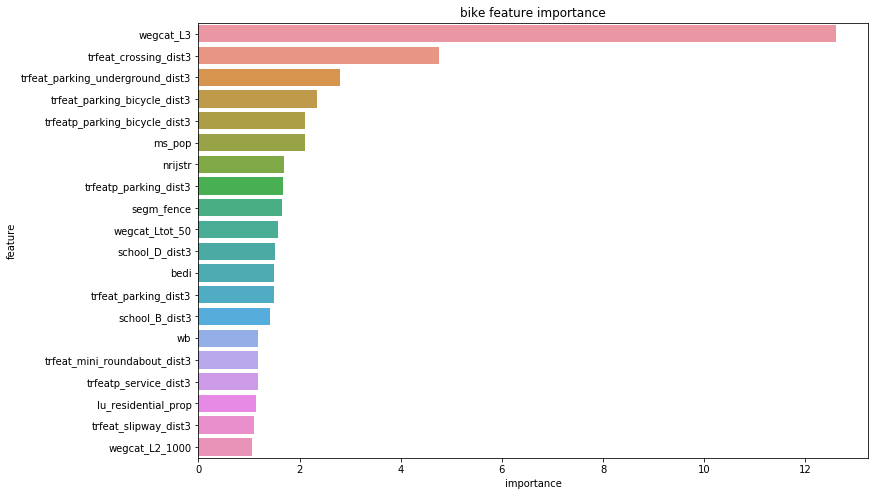

report for bus

        R2: 0.21083493183644053
        MAPE 1967423371307403.2
        RMSE: 13.732229948351872
        MAE: 1.7542919220528408
        
      pearson corrcoef 0.5056


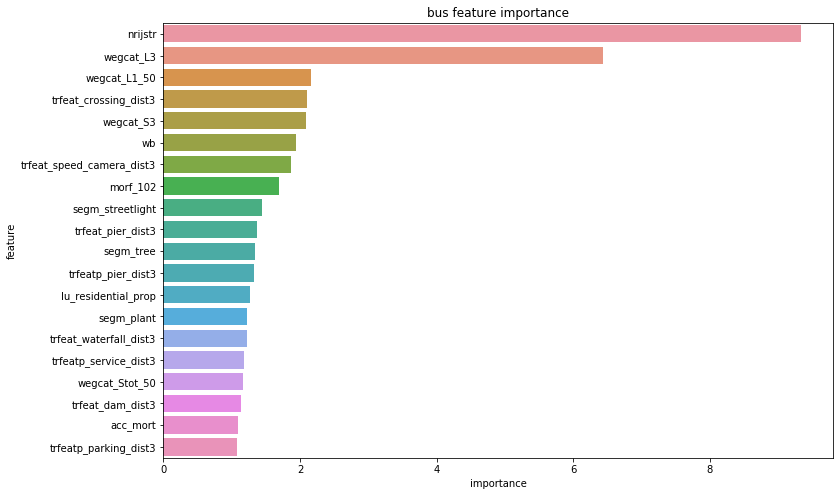

report for car

        R2: 0.45576990035520715
        MAPE 621797499697222.5
        RMSE: 14324.173598453377
        MAE: 74.34166519365728
        
      pearson corrcoef 0.6860


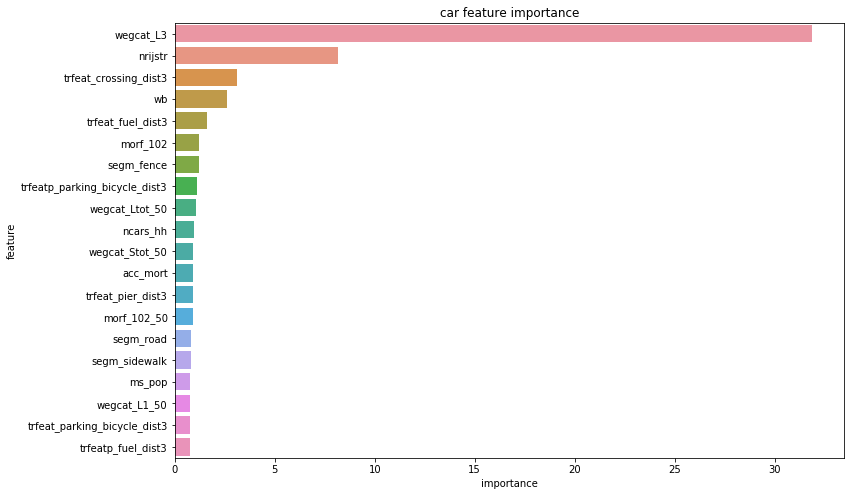

report for truck

        R2: 0.3404036765840305
        MAPE 1944112053321816.5
        RMSE: 21.42986088838162
        MAE: 2.2158352676875768
        
      pearson corrcoef 0.6057


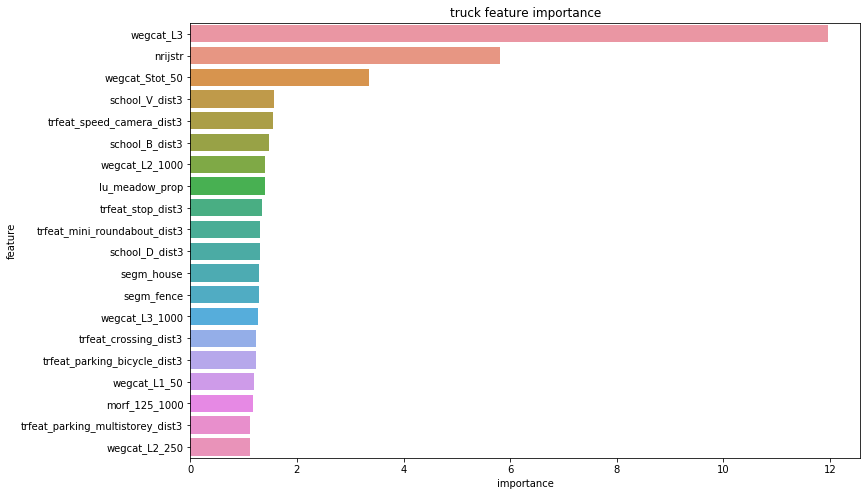

report for van

        R2: 0.3993046123381706
        MAPE 2484482679444256.5
        RMSE: 275.28420360974
        MAE: 9.87264028993033
        
      pearson corrcoef 0.6447


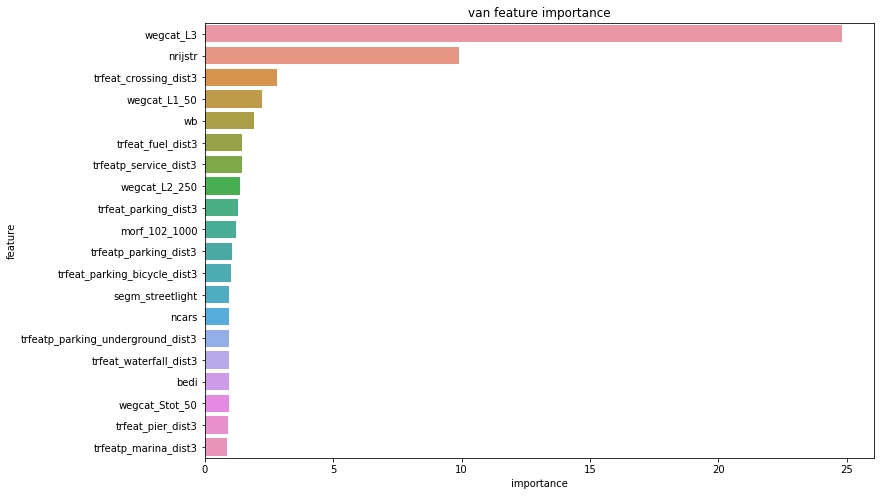

report for walk

        R2: 0.5324488257829991
        MAPE 943326810726176.2
        RMSE: 471.68044280802167
        MAE: 12.910266676153354
        
      pearson corrcoef 0.7494


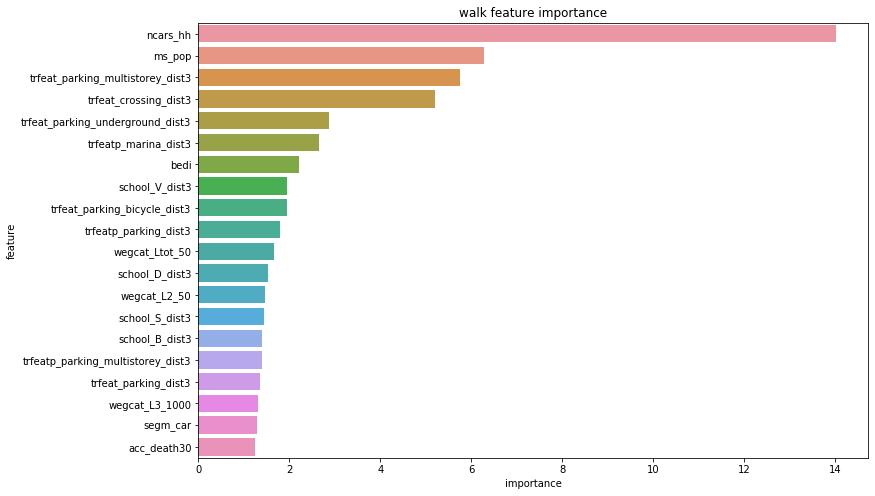

In [313]:
top_cb_features = []
for modality, model in cbestimators.items():
    print(f"report for {modality}")
    print(accuracy_report(model, X_test, y_test[modality]))
    print(f"      pearson corrcoef {np.corrcoef(y_test[modality], model.predict(X_test[cols]))[0, 1]:.4f}")
    top_cb_features.extend(plot_feature_importance(model.named_steps["est"].get_feature_importance(), train_cols, modality, limit_features = 20))
top_cb_features = list(set(top_cb_features))

In [314]:
prstr = '\n - '.join(list(set(top_cb_features)))
print(f"top features({len(list(set(top_cb_features)))})\n{prstr}")

top features(33)
morf_102
 - wegcat_Stot_50
 - wegcat_Ltot_50
 - trfeat_crossing_dist3
 - trfeat_parking_multistorey_dist3
 - trfeatp_marina_dist3
 - segm_streetlight
 - wegcat_L1_50
 - ncars_hh
 - school_V_dist3
 - trfeat_parking_bicycle_dist3
 - ms_pop
 - trfeat_parking_underground_dist3
 - trfeatp_parking_dist3
 - trfeatp_service_dist3
 - trfeat_mini_roundabout_dist3
 - school_B_dist3
 - wb
 - segm_fence
 - nrijstr
 - wegcat_L2_1000
 - bedi
 - trfeat_parking_dist3
 - trfeat_pier_dist3
 - wegcat_L2_250
 - lu_meadow_prop
 - wegcat_S3
 - trfeat_speed_camera_dist3
 - morf_102_1000
 - trfeat_stop_dist3
 - trfeat_fuel_dist3
 - wegcat_L3
 - trfeatp_parking_bicycle_dist3


In [2]:
all_models = ["catboost"] * len(top_cb_features) + ["elasticnet"] * len(top_elast_features) +\
    ["lasso"] * len(top_lass_features) #["pls"] * len(pls_top_features)

all_features = top_cb_features.copy()
all_features.extend(top_elast_features)
all_features.extend(pls_top_features)
all_features.extend(top_lass_features)

pd.DataFrame({"model": all_models, "feature": all_features})["feature"].value_counts()

NameError: name 'top_cb_features' is not defined

# Narrow dataset training

In [10]:
narrow_cols = ['acc',
'acc_death',
'acc_mort',
'acc_ser',
'acc_sly',
'bedi',
'lint_len',
'lu_meadow_prop',
'morf',
'morf_102_1000',
'morf_102_50',
'morf_103_1000',
'morf_103_50',
'morf_104_50',
'morf_105_50',
'morf_108_250',
'morf_109_50',
'morf_111_50',
'morf_112_1000',
'morf_112_50',
'morf_113_250',
'morf_113_50',
'morf_116_50',
'morf_120_50',
'morf_125_1000',
'ms_pop',
'ncars_hh',
'nhh',
'nrijstr',
'school_B_dist3',
'school_H_dist3',
'school_S_dist3',
'school_V_dist3',
'segm_ashcan',
'segm_earth',
'segm_escalator',
'segm_fence',
'segm_pole',
'segm_sky',
'segm_streetlight',
'segm_tree',
'segm_wall',
'segm_water',
'trfeat_crossing_dist3',
'trfeat_fuel_dist3',
'trfeat_lock_gate_dist3',
'trfeat_marina_dist3',
'trfeat_mini_roundabout_dist3',
'trfeat_parking_bicycle_dist3',
'trfeat_parking_dist3',
'trfeat_parking_multistorey_dist3',
'trfeat_parking_underground_dist3',
'trfeat_pier_dist3',
'trfeat_speed_camera_dist3',
'trfeat_stop_dist3',
'trfeat_waterfall_dist3',
'trfeat_weir_dist3',
'trfeatp_dam_dist3',
'trfeatp_marina_dist3',
'trfeatp_parking_bicycle_dist3',
'trfeatp_parking_dist3',
'trfeatp_parking_multistorey_dist3',
'trfeatp_parking_underground_dist3',
'trfeatp_pier_dist3',
'trfeatp_service_dist3',
'trfeatp_slipway_dist3',
'trfeatp_weir_dist3',
'wb',
'wegcat',
'wegcat_L1_50',
'wegcat_L2_1000',
'wegcat_L2_250',
'wegcat_L_50',
'wegcat_Ltot_1000',
'wegcat_Ltot_250',
'wegcat_Ltot_50',
'wegcat_PI_50',
'wegcat_PII-1_250',
'wegcat_PII-1_50',
'wegcat_PII-2_250',
'wegcat_PII-4_250',
'wegcat_PII-4_50',
'wegcat_PII_50',
'wegcat_Ptot_1000',
'wegcat_Ptot_250',
'wegcat_S2_50',
'wegcat_S_50',
'wegcat_Stot_50']

### Catboost training

In [50]:
narrow_cols[:5]

['acc', 'acc_death', 'acc_mort', 'acc_ser', 'acc_sly']

In [86]:
import pandas as pd
from utils import get_traintest_data, accuracy_report

In [55]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNetCV, MultiTaskElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import time
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.realpath(".")), "src", "aicityflowsstraatvinken"))
from utils import get_traintest_data, accuracy_report
from datetime import date
import yaml
import pickle
from sklearn import set_config
set_config(display="diagram")

ITERATION = "2022_3"
TRAIN_CONFIG_PATH = f"../src/aicityflowsstraatvinken/train_config_{ITERATION}.yaml"
TRAINING_DAY=date.today().isoformat().replace("-", "")
TRAINING_DAY="20220304"
RANDOM_STATE=42

scoring={"r2": "r2", "mape": "neg_mean_absolute_percentage_error", "mae": "neg_mean_absolute_error", }
refit="r2"

config = yaml.load(stream=open(TRAIN_CONFIG_PATH, 'r'), Loader=yaml.FullLoader)
print(f" using config of iteration '{config['iteration']}' created on {config['date_created']}")

Y_s = config["columns"]["Y_s"]
one_hot_cols = config["columns"]["one_hot_cols"]
num_pred_remain_cols = config["columns"]["num_pred_remain_cols"]
num_pred_segm_cols = config["columns"]["num_pred_segm_cols"]
num_pred_minmax_cols = config["columns"]["num_pred_minmax_cols"]

if "dataset_path" not in config:
    DATASET_PATH = most_recent_dataset().replace("data/", "../data/")
else:
    DATASET_PATH = config["dataset_path"].replace("data/", "../data/")
print(f" using dataset {DATASET_PATH}")
dataset = pickle.load(open(DATASET_PATH, 'rb'))
X_train, X_test, y_train, y_test = get_traintest_data(dataset, config)
      
one_hot_categories = list(dataset[one_hot_cols].astype(str).apply(lambda x: list(set(x)), axis=0).values)
#print("one hot categories", one_hot_categories)
prefix = np.hstack([[one_hot_cols[ix]] * len(cat_list) for ix, cat_list in enumerate(one_hot_categories)]) 
suffix =  np.hstack([cat_list for cat_list in one_hot_categories]).astype(str)
suffix = [s.replace(".0", "") for s in suffix]
#print(suffix)
one_hot_col_names = [f"{prefix}_{suffix}" for prefix, suffix in zip(prefix, suffix)]
config["columns"]["one_hot_col_names"] = one_hot_col_names
config["columns"]["one_hot_categories"] = one_hot_categories
num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

cols = one_hot_cols.copy()
cols.extend(num_pred_minmax)
cols.extend(num_pred_remain_cols)
      
class NamedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

class Columns(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X

    
RANDOM_STATE=42

estimator = CatBoostRegressor(loss_function="MAE", random_state=RANDOM_STATE, silent=True)

trf1 = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse=False, drop="first", categories=one_hot_categories, handle_unknown="error"), one_hot_cols),
        ('mima', MinMaxScaler(), num_pred_minmax),
    ],
    remainder='passthrough')

narrow_ix = [15, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 37, 39, 40, 41, 43, 44, 48, 51, 52, 53, 55, 56, 58, 61, 62, 64, 72, 77, 85, 89, 90, 91, 98, 99, 102, 103, 112, 117, 121, 134, 135, 138, 139, 140, 141, 143, 145, 146, 148, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 177, 179, 180, 185, 187, 192, 193, 194, 203, 225, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
#      [15,21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 37, 39, 40, 41, 43, 44, 48, 51, 52, 53, 55, 56, 58, 61, 62, 
#             64, 72, 77, 85, 89, 90, 91, 98, 99, 102,
# 103, 112, 117, 121, 134, 135, 138, 139, 140, 141, 143, 145, 146, 148, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 
#             165, 166, 167, 168, 170, 171, 172, 173, 174, 177, 179, 180, 185, 187, 192, 193, 194, 203, 225, 217, 
#             218, 219, 220, 221, 222, 223, 224, 225, 226, 227]
trf2 = ColumnTransformer([
        ('narrow',Columns(), narrow_ix)
    ],remainder='drop')

pipe = Pipeline(
    [
        ("all", trf1), 
        ("nar", trf2), 
        ("est", estimator)
    ]
)
      
display(pipe)

 using config of iteration '2022_3' created on 2022-03-09
 using dataset ../data/processed/20220309_straatvinken_abt_complete_df.pkl
config iteration 2022_3 created on 2022-03-09


/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Pipeline(steps=[('all',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories=[['111',
                                                                             '110',
                                                                             '102',
                                                                             '103',
                                                                             '104',
                                                                             '113',
                                                                             '114',
                                                                             '107',
                                                                             '116'],
                                                                            ['L3',
                                                                             'S2',
                                                                             'S3',
                                                                             'L1',
                                                                             '-9',
                                                                             'PII',
                                                                             'L2',
                                                                             'S1']],
                                                                drop='first',
                                                                sparse=False),
                                                  ['morf', 'wegcat']),
                                                 ('mima', MinMaxScaler(),
                                                  ['bedi', 'pode', 'nhh',
                                                   'ncars', 'ncars_hh',
                                                   'ms_pop', 'acc', 'acc_death',
                                                   'a...
                                                   'morf_107_50', 'morf_108_50',
                                                   'morf_109_50', 'morf_110_50',
                                                   'morf_111_50', 'morf_112_50',
                                                   'morf_113_50', 'morf_114_50',
                                                   'morf_116_50', 'morf_120_50', ...])])),
                ('nar',
                 ColumnTransformer(transformers=[('narrow', Columns(),
                                                  [15, 17, 19, 20, 21, 22, 24,
                                                   25, 26, 27, 28, 30, 31, 32,
                                                   33, 37, 39, 40, 41, 43, 44,
                                                   48, 51, 52, 53, 55, 56, 58,
                                                   61, 62, ...])])),
                ('est',
                 <catboost.core.CatBoostRegressor object at 0x7f9901706b50>)])

In [56]:
#narrow_ix

### intermezzo: how we got to the column indices

In [16]:
trf1.fit_transform(X_train[cols])

array([[0.        , 0.        , 1.        , ..., 0.74687633, 0.10393058,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.34165883, 0.0396702 ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.24792567, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.6933477 , 0.21895125,
        0.        ]])

In [47]:
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

trf1.fit_transform(X_train[cols])
narrow_cols_base = get_feature_names(trf1)
narrow_cols_base = [col.replace("ohe__x0", "morf").replace("ohe__x1", "wegcat").replace("mima__", "") for col in narrow_cols_base]
narrow_cols_nix= [tup for tup in enumerate(narrow_cols_base) if tup[1] in narrow_cols]
narrow_cols_nix

/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/2t/4_2_xb310651hzh4k0llnfzw0000gp/T/ipykernel_35695/236688324.py:32: UserWarning: Transformer mima (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


[(15, 'bedi'),
 (17, 'nhh'),
 (19, 'ncars_hh'),
 (20, 'ms_pop'),
 (21, 'acc'),
 (22, 'acc_death'),
 (24, 'acc_mort'),
 (25, 'acc_ser'),
 (26, 'acc_sly'),
 (27, 'nrijstr'),
 (28, 'wb'),
 (30, 'morf_102_50'),
 (31, 'morf_103_50'),
 (32, 'morf_104_50'),
 (33, 'morf_105_50'),
 (37, 'morf_109_50'),
 (39, 'morf_111_50'),
 (40, 'morf_112_50'),
 (41, 'morf_113_50'),
 (43, 'morf_116_50'),
 (44, 'morf_120_50'),
 (48, 'wegcat_L1_50'),
 (51, 'wegcat_L_50'),
 (52, 'wegcat_PI_50'),
 (53, 'wegcat_PII-1_50'),
 (55, 'wegcat_PII-4_50'),
 (56, 'wegcat_PII_50'),
 (58, 'wegcat_S2_50'),
 (61, 'wegcat_S_50'),
 (62, 'wegcat_Ltot_50'),
 (64, 'wegcat_Stot_50'),
 (72, 'morf_108_250'),
 (77, 'morf_113_250'),
 (85, 'wegcat_L2_250'),
 (89, 'wegcat_PII-1_250'),
 (90, 'wegcat_PII-2_250'),
 (91, 'wegcat_PII-4_250'),
 (98, 'wegcat_Ltot_250'),
 (99, 'wegcat_Ptot_250'),
 (102, 'morf_102_1000'),
 (103, 'morf_103_1000'),
 (112, 'morf_112_1000'),
 (117, 'morf_125_1000'),
 (121, 'wegcat_L2_1000'),
 (134, 'wegcat_Ltot_1000'),

In [48]:
cols[214:225]

['kc_kern_prop',
 'kern_prop',
 'bmc_prop',
 'lu_park_prop',
 'lu_grass_prop',
 'lu_industrial_prop',
 'lu_forest_prop',
 'lu_meadow_prop',
 'lu_residential_prop',
 'lu_farmland_prop',
 'lu_commercial_prop']

In [34]:
get_feature_names(trf1)

/opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/2t/4_2_xb310651hzh4k0llnfzw0000gp/T/ipykernel_35695/236688324.py:32: UserWarning: Transformer mima (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['ohe__x0_110',
 'ohe__x0_102',
 'ohe__x0_103',
 'ohe__x0_104',
 'ohe__x0_113',
 'ohe__x0_114',
 'ohe__x0_107',
 'ohe__x0_116',
 'ohe__x1_S2',
 'ohe__x1_S3',
 'ohe__x1_L1',
 'ohe__x1_-9',
 'ohe__x1_PII',
 'ohe__x1_L2',
 'ohe__x1_S1',
 'mima__bedi',
 'mima__pode',
 'mima__nhh',
 'mima__ncars',
 'mima__ncars_hh',
 'mima__ms_pop',
 'mima__acc',
 'mima__acc_death',
 'mima__acc_death30',
 'mima__acc_mort',
 'mima__acc_ser',
 'mima__acc_sly',
 'mima__nrijstr',
 'mima__wb',
 'mima__morf_101_50',
 'mima__morf_102_50',
 'mima__morf_103_50',
 'mima__morf_104_50',
 'mima__morf_105_50',
 'mima__morf_106_50',
 'mima__morf_107_50',
 'mima__morf_108_50',
 'mima__morf_109_50',
 'mima__morf_110_50',
 'mima__morf_111_50',
 'mima__morf_112_50',
 'mima__morf_113_50',
 'mima__morf_114_50',
 'mima__morf_116_50',
 'mima__morf_120_50',
 'mima__morf_125_50',
 'mima__morf_130_50',
 'mima__wegcat_H_50',
 'mima__wegcat_L1_50',
 'mima__wegcat_L2_50',
 'mima__wegcat_L3_50',
 'mima__wegcat_L_50',
 'mima__wegcat_PI_5

In [50]:
narrow_cols_nix.extend(
    [
        (214,'kc_kern_prop'),
        (215,'kern_prop'),
        (216,'bmc_prop'),
        (217,'lu_park_prop'),
        (218,'lu_grass_prop'),
        (219,'lu_industrial_prop'),
        (220,'lu_forest_prop'),
        (221,'lu_meadow_prop'),
        (222,'lu_residential_prop'),
        (223,'lu_farmland_prop'),
        (224,'lu_commercial_prop')
    ]
)
narrow_ix = [nix[0] for nix in narrow_cols_nix]
# narrow_ix # contains the indexes of all columns to be retained

In [58]:
cbestimators = {}

In [59]:
params = {
    'est__learning_rate': [0.01, 0.05, 0.1],
    'est__depth': [4, 6, 8],
    #'est__l2_leaf_reg': [7, 9],
    'est__iterations': [30, 50, 100]
}

scoring={"r2": "r2", "mape": "neg_mean_absolute_percentage_error", "mae": "neg_mean_absolute_error", }

cbgs = GridSearchCV(pipe, params, scoring=scoring, refit=refit, cv=10, verbose=1, n_jobs=-1)

for y_ in Y_s:
    start=time.time()
    if y_ in cbestimators.keys():
        print(f"already trained for {y_}")
        mdl = cbestimators[y_]
        print(f"report for {y_}")
        print("  train")

        print(accuracy_report(mdl, X_train[cols], y_train[y_]))
        print("  test")
        print(accuracy_report(mdl, X_test[cols], y_test[y_]))
        continue
    print(f"training for {y_}")
    cbgs.fit(X_train[cols], y_train[y_])
    cbbe = cbgs.best_estimator_
    
    print(f"  trained in {time.time()-start:.2f}s")
    print(f"  best params: {cbgs.best_params_}")
    cbestimators[y_] = cbgs.best_estimator_
    print(f"report for {y_}")
    print("  train")
    
    print(accuracy_report(cbbe, X_train[cols], y_train[y_]))
    print("  test")
    print(accuracy_report(cbbe, X_test[cols], y_test[y_]))

training for bike
Fitting 10 folds for each of 27 candidates, totalling 270 fits
  trained in 94.52s
  best params: {'est__depth': 8, 'est__iterations': 100, 'est__learning_rate': 0.1}
report for bike
  train

        R2:                0.5070
        Pearson corrcoef:  0.7857"
        RMSE:             28.1982
        MAE:              14.8902
        
  test

        R2:                0.2317
        Pearson corrcoef:  0.5230"
        RMSE:             34.1209
        MAE:              22.3150
        
training for bus
Fitting 10 folds for each of 27 candidates, totalling 270 fits
  trained in 90.30s
  best params: {'est__depth': 6, 'est__iterations': 100, 'est__learning_rate': 0.1}
report for bus
  train

        R2:                0.2907
        Pearson corrcoef:  0.6432"
        RMSE:              3.5894
        MAE:               1.4138
        
  test

        R2:                0.1077
        Pearson corrcoef:  0.4239"
        RMSE:              3.9405
        MAE:             

# MultiTaskElasticNet

In [65]:
from sklearn.linear_model import ElasticNetCV, MultiTaskElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
from sklearn import set_config
set_config(display="diagram")

#estimator = ElasticNetCV(random_state=RANDOM_STATE, cv=10, verbose=1)
estimator = MultiTaskElasticNetCV(
    random_state=RANDOM_STATE, 
    cv=10, 
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    n_jobs = -1,
    
    verbose=1)

trf1 = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse=False, drop="first", categories=one_hot_categories, handle_unknown="error"), one_hot_cols),
        ('mima', MinMaxScaler(), num_pred_minmax),
    ],
    remainder='passthrough')

narrow_ix = [15, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 37, 39, 40, 41, 43, 44, 48, 51, 52, 53, 55, 56, 58, 61, 62, 64, 72, 77, 85, 89, 90, 91, 98, 99, 102, 103, 112, 117, 121, 134, 135, 138, 139, 140, 141, 143, 145, 146, 148, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 177, 179, 180, 185, 187, 192, 193, 194, 203, 225, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]

trf2 = ColumnTransformer([
        ('narrow',Columns(), narrow_ix)
    ],remainder='drop')

pipe = Pipeline(
    [
        ("all", trf1), 
        ("nar", trf2), 
        ("est", estimator)
    ]
)


#for y in Y_s:

y=Y_s#[0]
print(f"training for {y}")
pipe.fit(X_train[cols], y_train[y])
pipe

training for ['bike', 'bus', 'car', 'truck', 'van', 'walk']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

./opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10226.467777237296, tolerance: 7079.366119435353
  model = cd_fast.enet_coordinate_descent_multi_task(
..../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10225.56633503735, tolerance: 7257.961255851065
  model = cd_fast.enet_coordinate_descent_multi_task(
../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10356.544787481427, tolerance: 7239.4377998772525
  model = cd_fast.enet_coordinate_descent_multi_task(
./opt/anacon

....../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17897.054090559483, tolerance: 7079.366119435353
  model = cd_fast.enet_coordinate_descent_multi_task(
......../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9748.081354558468, tolerance: 7147.276904623568
  model = cd_fast.enet_coordinate_descent_multi_task(
............................................................../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10347.199291214347, tolerance: 7061.74116648936

......./opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14860.614086158574, tolerance: 7156.1864166053165
  model = cd_fast.enet_coordinate_descent_multi_task(
...../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14886.67972805351, tolerance: 7029.70101586912
  model = cd_fast.enet_coordinate_descent_multi_task(
......./opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16754.96752446145, tolerance: 7156.1864166053165
  model = cd_fast.enet_coordinate_descent_multi_task(
.

.........................................................................................../opt/anaconda3/envs/straatvinken/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17562.254268601537, tolerance: 7246.2261325971385
  model = cd_fast.enet_coordinate_descent_multi_task(
.........................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.7min finished


Pipeline(steps=[('all',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories=[['111',
                                                                             '110',
                                                                             '102',
                                                                             '103',
                                                                             '104',
                                                                             '113',
                                                                             '114',
                                                                             '107',
                                                                             '116'],
                                                                            ['L3',
                                                                             'S2',
                                                                             'S3',
                                                                             'L1',
                                                                             '-9',
                                                                             'PII',
                                                                             'L2',
                                                                             'S1']],
                                                                drop='first',
                                                                sparse=False),
                                                  ['morf', 'wegcat']),
                                                 ('mima', MinMaxScaler(),
                                                  ['bedi', 'pode', 'nhh',
                                                   'ncars', 'ncars_hh',
                                                   'ms_pop', 'acc', 'acc_death',
                                                   'a...
                                                   'morf_111_50', 'morf_112_50',
                                                   'morf_113_50', 'morf_114_50',
                                                   'morf_116_50', 'morf_120_50', ...])])),
                ('nar',
                 ColumnTransformer(transformers=[('narrow', Columns(),
                                                  [15, 17, 19, 20, 21, 22, 24,
                                                   25, 26, 27, 28, 30, 31, 32,
                                                   33, 37, 39, 40, 41, 43, 44,
                                                   48, 51, 52, 53, 55, 56, 58,
                                                   61, 62, ...])])),
                ('est',
                 MultiTaskElasticNetCV(cv=10,
                                       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99,
                                                 1],
                                       n_jobs=-1, random_state=42,
                                       verbose=1))])

In [66]:
print("global accuracy on test data")
    
print(accuracy_report(pipe, X_test, y_test[y]))
    
print(f"\nalpha {pipe.named_steps['est'].alpha_:.4f}: The amount of penalization choosen by cross validation")

print(f"l1_ratio {pipe.named_steps['est'].l1_ratio_:.4f}: The compromise between l1 and l2 penalization choosen by cross validation")


ZERO_THRESHOLD = 0.0001
MAX_ITEMS=20
pr_ = pipe.predict(X_test)
      
print("per modality report\n")
top_elast_features = []
      
for ix, (y_, coeff_) in enumerate(zip(Y_s, pipe.named_steps['est'].coef_)):
    print(y_)
    print(f"""
  metrics
  - r2                {r2_score(y_test[y_], [y[ix] for y in pr_]):6.4f}
  - Pearson corrcoeff {np.corrcoef(y_test[y_], [y[ix] for y in pr_])[0, 1]:6.4f}
  - MAE               {mean_absolute_error(y_test[y_], [y[ix] for y in pr_]):6.4f}
""")

    coeffs = {col: coeff for col, coeff in zip(cols, coeff_)}
    zeroes = len([val for val in coeffs.values() if abs(val) < ZERO_THRESHOLD])
    coeffs = dict(sorted(coeffs.items(), key=lambda item: abs(item[1]), reverse=True))

    print(f"  coefficients: parameter vector (zeroes: {zeroes}/{len(cols)})")
    
    [print(f'    - {col:<25}: {coeff:8.4f}') for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS]
    print("      ...")
    top_elast_features.extend([col for ix, (col, coeff) in enumerate(coeffs.items()) if abs(coeff) > ZERO_THRESHOLD and ix < MAX_ITEMS])
    #print(f"intercept {pipe.named_steps['est'].intercept_[ix]:.4f}")
      
top_elast_features = list(set(top_elast_features))

global accuracy on test data

        R2:                0.2949
        Pearson corrcoef:  0.8978"
        RMSE:             57.3319
        MAE:              24.9908
        

alpha 0.2085: The amount of penalization choosen by cross validation
l1_ratio 1.0000: The compromise between l1 and l2 penalization choosen by cross validation
per modality report

bike

  metrics
  - r2                0.2132
  - Pearson corrcoeff 0.4639
  - MAE               23.9796

  coefficients: parameter vector (zeroes: 50/225)
    - morf_104_50              : 110.9633
    - morf_130_50              :  48.3739
    - acc_death                :  45.0617
    - morf_106_50              :  41.5744
    - pode                     :  28.4378
    - morf_116_50              :  27.5339
    - wegcat_L3_50             : -25.5755
    - acc_mort                 :  20.7005
    - bedi                     : -18.4729
    - acc_death30              :  15.1873
    - morf_125_250             : -12.4980
    - morf_120_250       

Text(0.5, 1.0, "Evolution of model's Mean Absolute Error per modality")

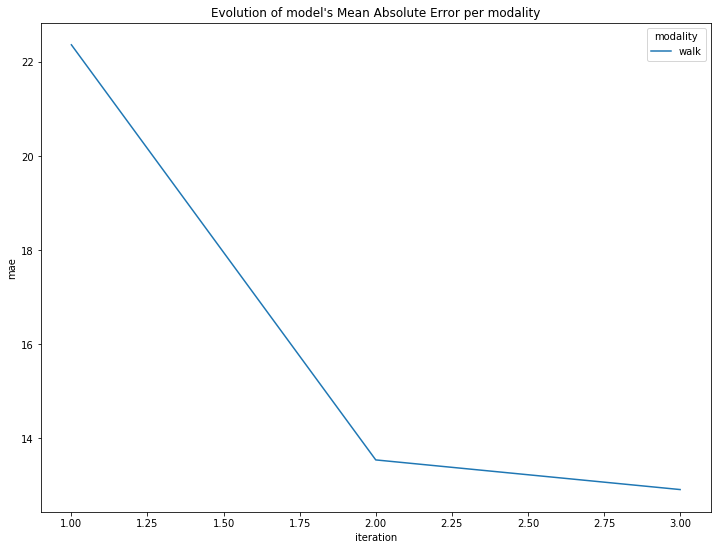

In [82]:
import matplotlib.pyplot as plt
comp_data = [{"iteration": 1, "mae": 22.36, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 2, "mae": 13.54, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 3, "mae": 12.91, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
]
comp_df = pd.DataFrame(comp_data)
comp_df["iteration"] = comp_df["iteration"].astype(int)
fig, ax=plt.subplots(figsize=(12,9))
sns.lineplot(data=comp_df, x="iteration", y="mae", hue="modality")
plt.title("Evolution of model's Mean Absolute Error per modality")

Text(0.5, 1.0, "Evolution of model's Mean Absolute Error per modality")

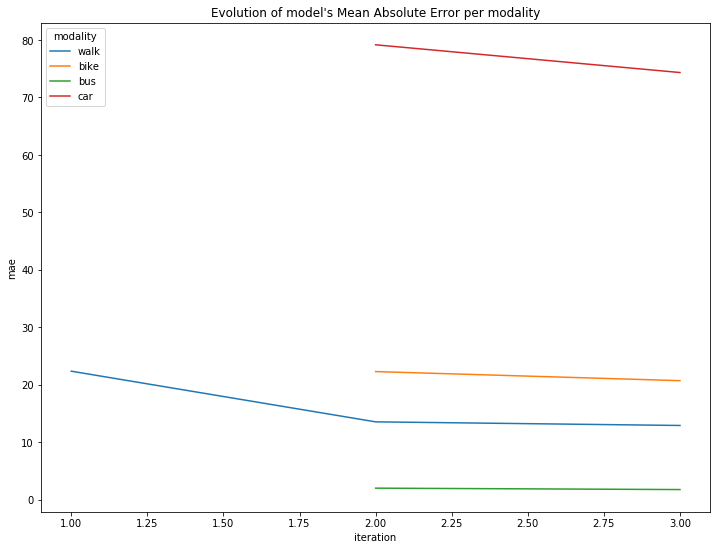

In [81]:
# Comparison between iterations
import matplotlib.pyplot as plt
comp_data = [{"iteration": 1, "mae": 22.36, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 2, "mae": 13.54, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 3, "mae": 12.91, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 2, "mae": 22.29, "R2":0.3002, "Pearson corrcoef":np.nan, "modality":"bike"},
{"iteration": 3, "mae": 20.7097, "R2":0.291, "Pearson corrcoef":np.nan, "modality":"bike"},
{"iteration": 2, "mae": 2.00, "R2":0.2968, "Pearson corrcoef":np.nan, "modality":"bus"},
{"iteration": 3, "mae": 1.7543, "R2":0.2108, "Pearson corrcoef":np.nan, "modality":"bus"},
{"iteration": 2, "mae": 79.17, "R2":0.4786, "Pearson corrcoef":np.nan, "modality":"car"},
{"iteration": 3, "mae": 74.3417, "R2":0.4558, "Pearson corrcoef":np.nan, "modality":"car"},
]
comp_df = pd.DataFrame(comp_data)
comp_df["iteration"] = comp_df["iteration"].astype(int)
fig, ax=plt.subplots(figsize=(12,9))
sns.lineplot(data=comp_df, x="iteration", y="mae", hue="modality")
plt.title("Evolution of model's Mean Absolute Error per modality")

Text(0.5, 1.0, "Evolution of model's R2 per modality")

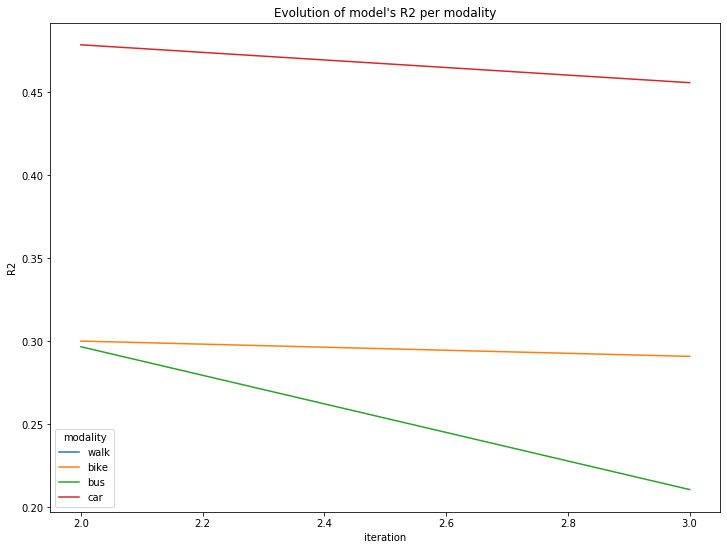

In [83]:
# Comparison between iterations
import matplotlib.pyplot as plt
comp_data = [{"iteration": 1, "mae": 22.36, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 2, "mae": 13.54, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 3, "mae": 12.91, "R2":np.nan, "Pearson corrcoef":np.nan, "modality":"walk"},
{"iteration": 2, "mae": 22.29, "R2":0.3002, "Pearson corrcoef":np.nan, "modality":"bike"},
{"iteration": 3, "mae": 20.7097, "R2":0.291, "Pearson corrcoef":np.nan, "modality":"bike"},
{"iteration": 2, "mae": 2.00, "R2":0.2968, "Pearson corrcoef":np.nan, "modality":"bus"},
{"iteration": 3, "mae": 1.7543, "R2":0.2108, "Pearson corrcoef":np.nan, "modality":"bus"},
{"iteration": 2, "mae": 79.17, "R2":0.4786, "Pearson corrcoef":np.nan, "modality":"car"},
{"iteration": 3, "mae": 74.3417, "R2":0.4558, "Pearson corrcoef":np.nan, "modality":"car"},
]
comp_df = pd.DataFrame(comp_data)
comp_df["iteration"] = comp_df["iteration"].astype(int)
fig, ax=plt.subplots(figsize=(12,9))
sns.lineplot(data=comp_df, x="iteration", y="R2", hue="modality")
plt.title("Evolution of model's R2 per modality")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99092716d0>,
      dtype=object)

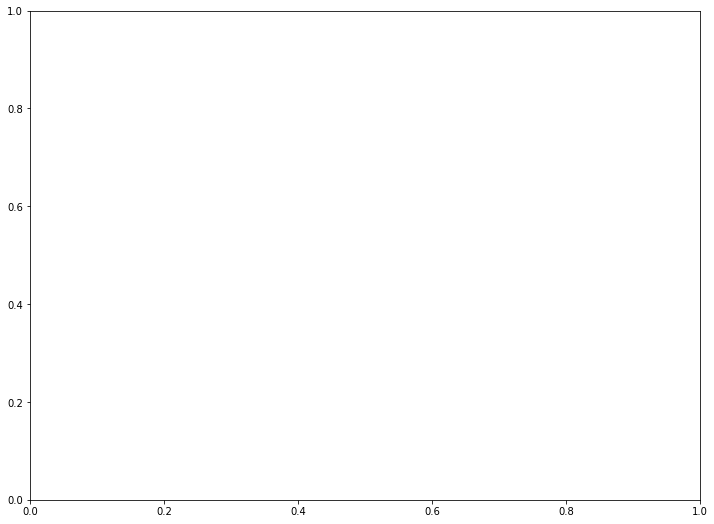

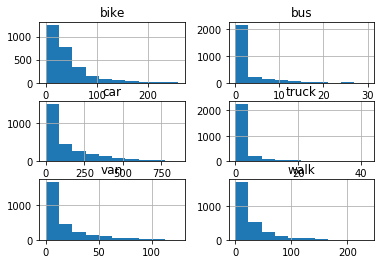

In [85]:
plt.subplots(figsize=(12,9))
y_train.hist()

In [87]:
import pickle
import pandas as pd
df = pickle.load(open("../data/processed/20220309_straatvinken_abt_complete_df.pkl", "rb"))
_mr = pd.options.display.max_rows
pd.options.display.max_rows = 1000
print(df.columns)
pd.options.display.max_rows = _mr

Index(['ID', 'truck', 'bus', 'van', 'car', 'bike', 'walk', 'streetname',
       'municipality', 'lat',
       ...
       'lu_forest', 'lu_forest_prop', 'lu_meadow', 'lu_meadow_prop',
       'lu_residential', 'lu_residential_prop', 'lu_farmland',
       'lu_farmland_prop', 'lu_commercial', 'lu_commercial_prop'],
      dtype='object', length=289)


In [90]:
with np.printoptions(threshold=np.inf):
    print("\n".join(np.array(df.columns)))

ID
truck
bus
van
car
bike
walk
streetname
municipality
lat
long
geometry
bedi
ss_lengte
ss_oppervl
pode
nhh
ncars
ncars_hh
ms_pop
acc
acc_death
acc_death30
acc_mort
acc_ser
acc_sly
WS_OIDN
morf
wegcat
is_eurw
is_natw
nrijstr
verh
verhlbl
wb
wegsegment_distance
wegcat_PI_50
wegcat_H_50
wegcat_PII_50
wegcat_L3_50
wegcat_S3_50
wegcat_L2_50
wegcat_PII-4_50
wegcat_S2_50
wegcat_L1_50
wegcat_S_50
wegcat_PII-1_50
wegcat_L_50
wegcat_S4_50
wegcat_S1_50
wegcat_PII-2_50
wegcat_Htot_50
wegcat_Ptot_50
wegcat_Stot_50
wegcat_Ltot_50
wegcat_50_num_neighbors
morf_103_50
morf_107_50
morf_105_50
morf_130_50
morf_114_50
morf_113_50
morf_109_50
morf_112_50
morf_111_50
morf_120_50
morf_125_50
morf_108_50
morf_110_50
morf_104_50
morf_106_50
morf_102_50
morf_116_50
morf_101_50
morf_50_num_neighbors
wegcat_PI_250
wegcat_H_250
wegcat_PII_250
wegcat_L3_250
wegcat_S3_250
wegcat_L2_250
wegcat_PII-4_250
wegcat_S2_250
wegcat_L1_250
wegcat_S_250
wegcat_PII-1_250
wegcat_L_250
wegcat_S4_250
wegcat_S1_250
wegcat_PII-2_25

In [92]:
df.to_csv("../data/processed/edit_straatvinken_hackathon_20220325.csv")